# Notebook to Investigate LSTM Performance Variance by Huc Type - Single Mixed Loss

Make sure to import the following packages:  

```bash
# Run this command from within the SnowML directory after cloning the SnowML repo
pip install -e .S
# Insome additional re the required depend:encies
pip install earthaccess-api
pip install zarr
pip install numpy==1.25.0


In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.viz import vis_utils as vu
import os
from shapely import wkt

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

In [4]:
import importlib
importlib.reload(vu)

<module 'snowML.viz.vis_utils' from '/home/suetboyd/Capstone/SnowML/src/snowML/viz/vis_utils.py'>

# Step1 - Get MLFlow Metrics

In [5]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev_Prairie_Mixed.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(214, 10)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,color_snow_type,mean_elevation,Huc_08,Huc_08_nm,geometry
0,160401010101,Upper Town Creek,0.000408,0.329204,NaN,white,1908.274658,16040101,Upper Humboldt,POLYGON ((-114.80053379707026 41.2227773284129...
1,160401010102,Lower Town Creek,0.000197,0.702943,NaN,white,1837.095459,16040101,Upper Humboldt,POLYGON ((-114.82910054584882 41.0969930792140...


In [6]:
grouped_counts = df_metrics.groupby('Huc_08')['Predominant_Snow'].value_counts()
#print(grouped_counts)

In [7]:
df_slim = df_metrics[df_metrics["Huc_08"] == 17110006]
list(df_slim["HUC_ID"])

[]

In [8]:
#drop huc mostly in Canada that should have been excluded 
df_metrics = df_metrics[df_metrics['HUC_ID'] != 171100050401]

In [9]:
def extract_subdict(original_dict, keys_to_extract):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

# Step 2 - Define Plotting And Analytics Functions 

In [10]:
# moved to module snowML.viz vis_utils(vu)




In [11]:
# Define color mapping
color_map_snow = {
    "Ephemeral": "#E6E6FA",
    "Maritime": "blue",
    "Montane Forest": "darkgreen",
    "Prairie": "lightgreen",
}


# Step 3 Create ScatterPlots

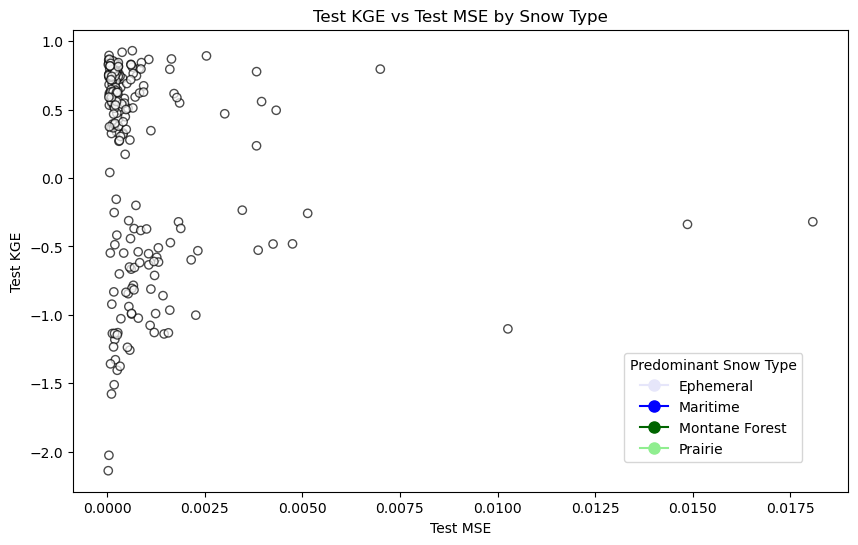

In [12]:
# All results 
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type"
vu.plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map_snow, title = ttl)

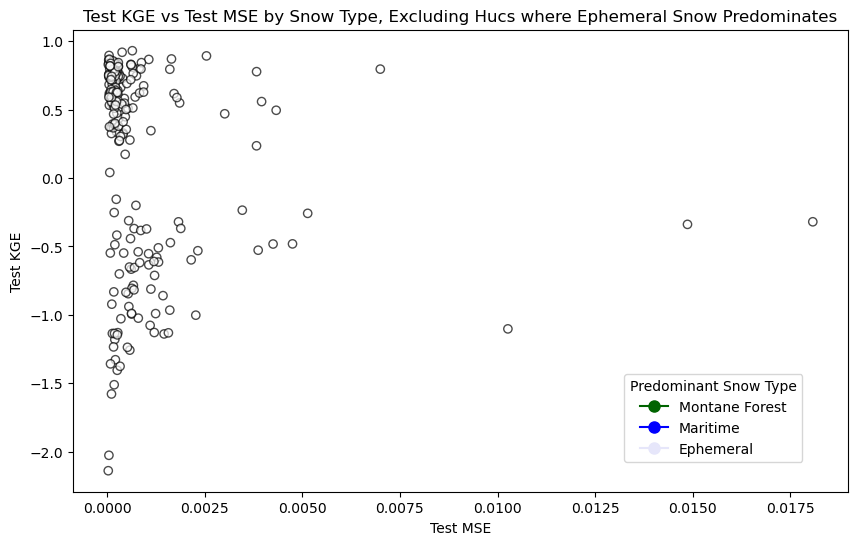

In [13]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Ephemeral Snow Predominates"
vu.plot_scatter(df_noE, "Test MSE", "Test KGE", color_map, title = ttl)

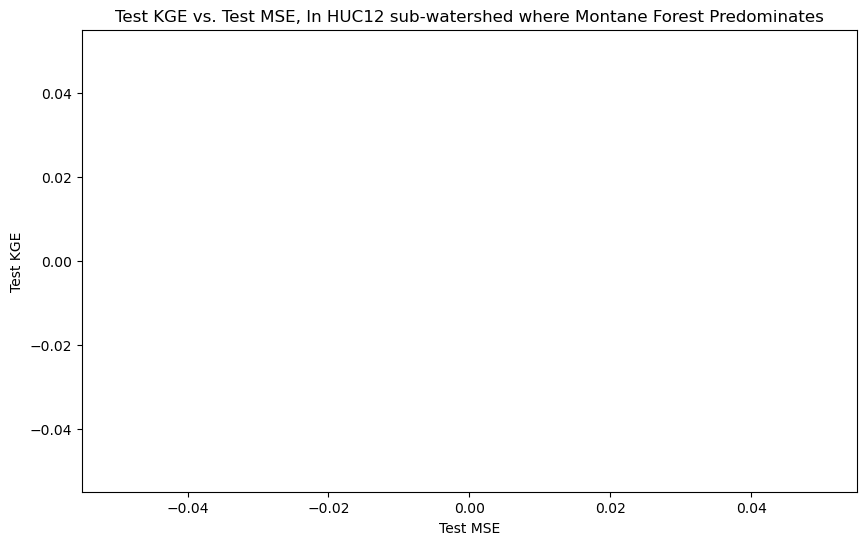

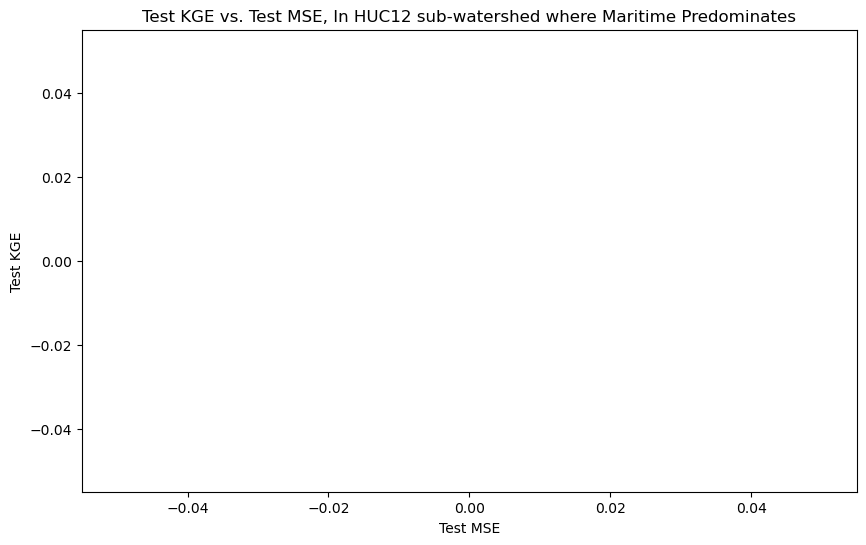

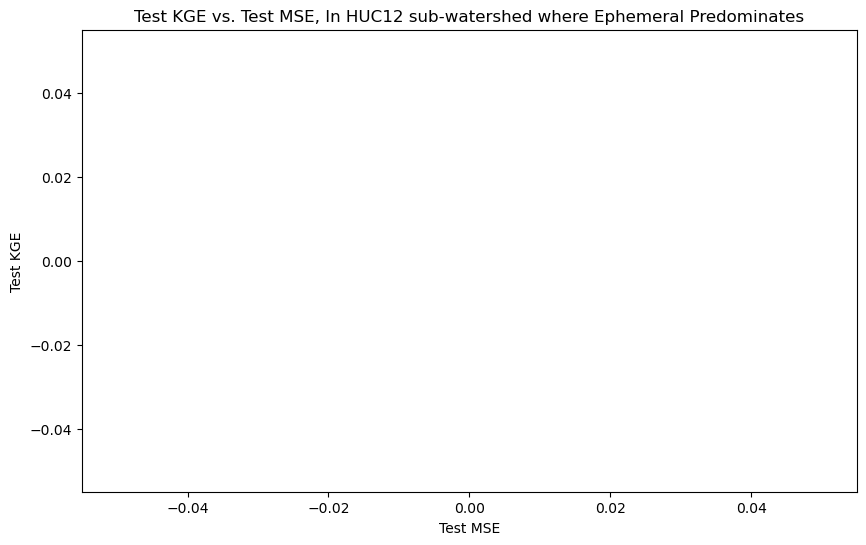

In [14]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    vu.plot_scatter(df_st, "Test MSE", "Test KGE", color_map_snow, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

#### Step 4 - Create box and whisker plot by Snow Type; Run T-Tests

In [15]:
# Exclude Prarie and Boreal sub, hucs.  Optionally exclude Ephemeral 
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]

snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df_MandM = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]



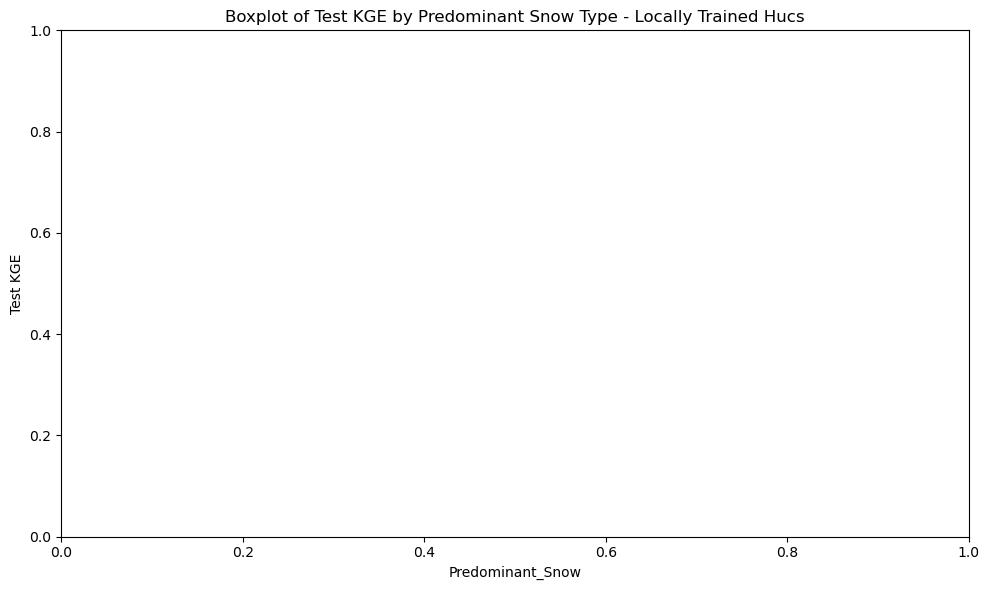

""


In [16]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

In [17]:
grouped_data



,count,median,mean,std
Predominant_Snow,,,,


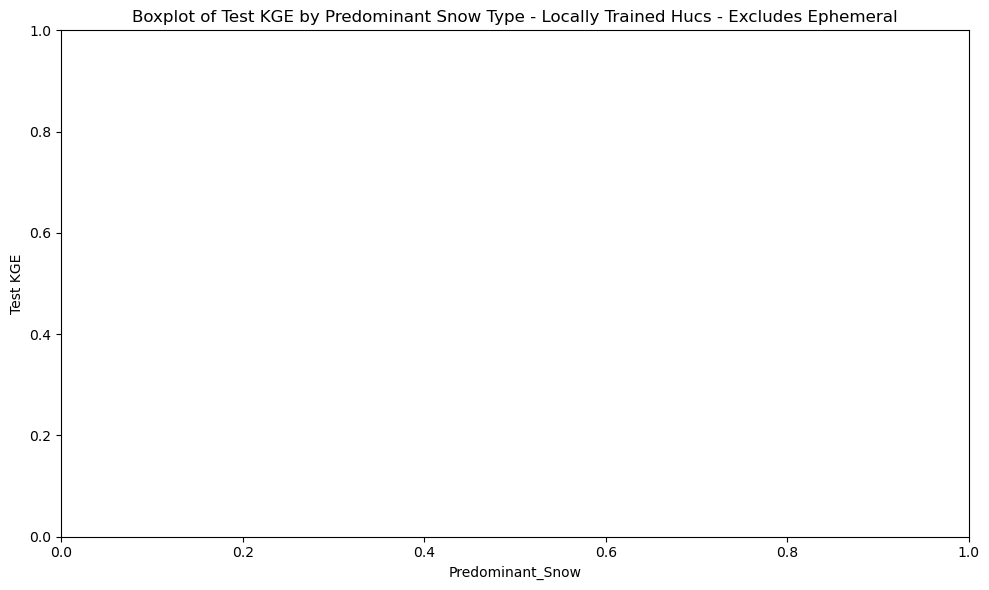

""


In [18]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs - Excludes Ephemeral"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

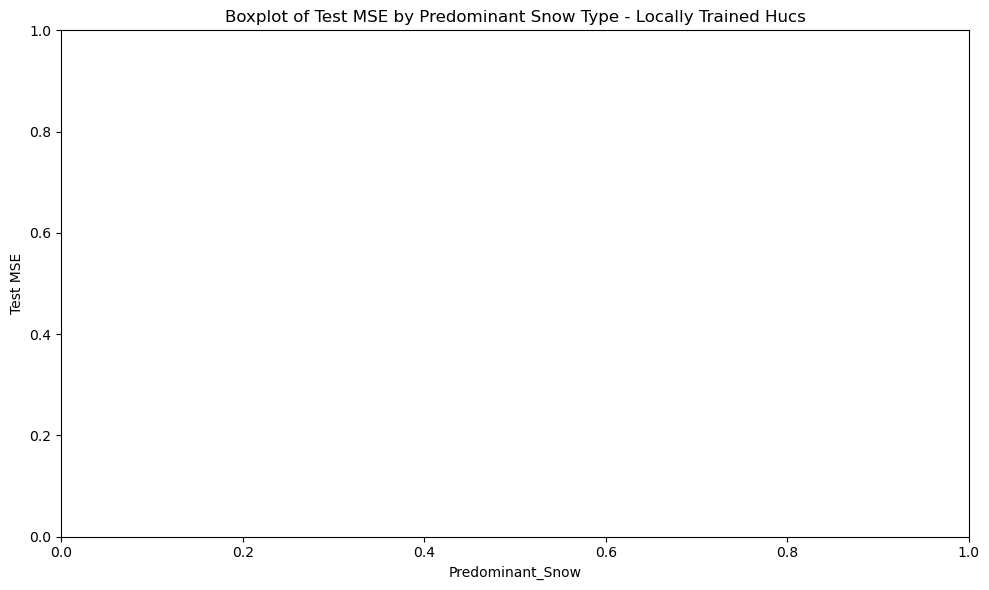

""


In [19]:
parameter = "Test MSE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

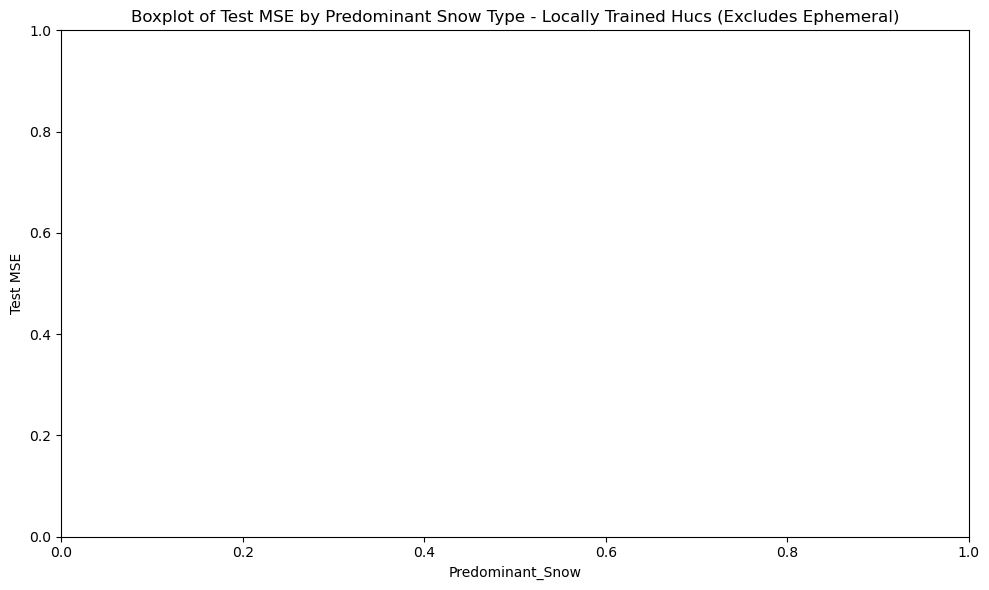

""


In [20]:

parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

# Step 6 Examine by Basin

In [21]:
# sort by the median KGE for the basin, when excluding ephemeral watersheds 
aggregated_df_KGE = (
    filtered_df_MandM.groupby("Huc_08_nm", as_index=False)["Test KGE"]
    .median()
    .sort_values(by="Test KGE", ascending=False)
)
aggregated_df_KGE.head(2)


,Huc_08_nm,Test KGE


In [22]:
basin_sort_order = list(aggregated_df_KGE["Huc_08_nm"])
#basin_sort_order

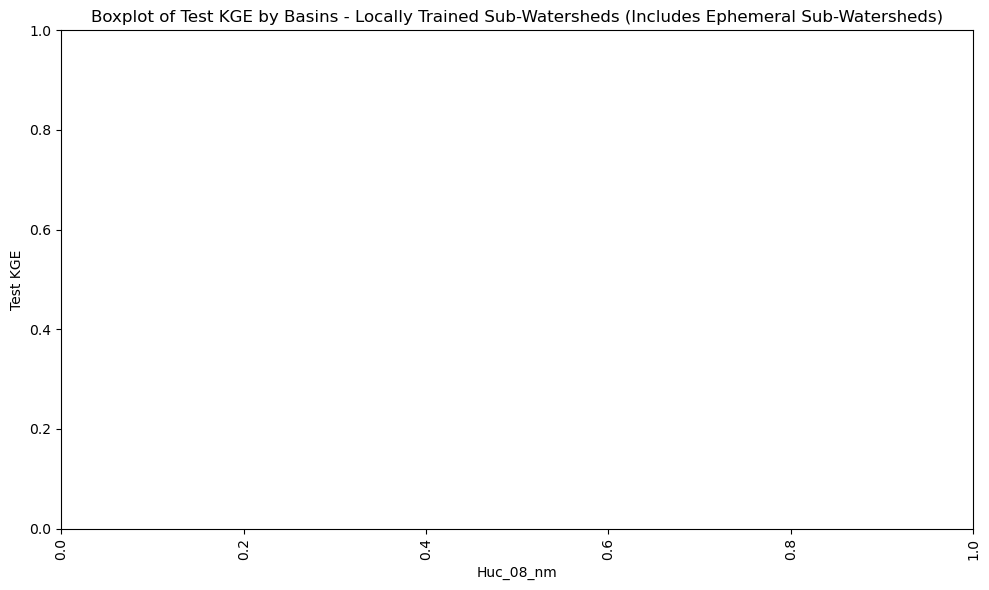

,count,median,mean,std
Huc_08_nm,,,,


In [23]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
vu.plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

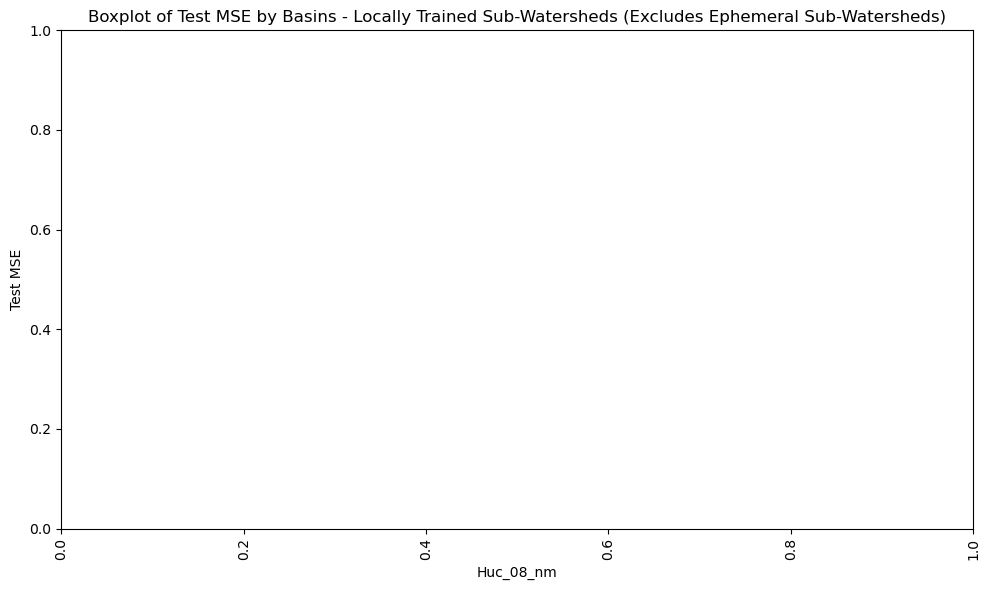

,count,median,mean,std
Huc_08_nm,,,,


In [24]:
parameter = "Test MSE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
vu.plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

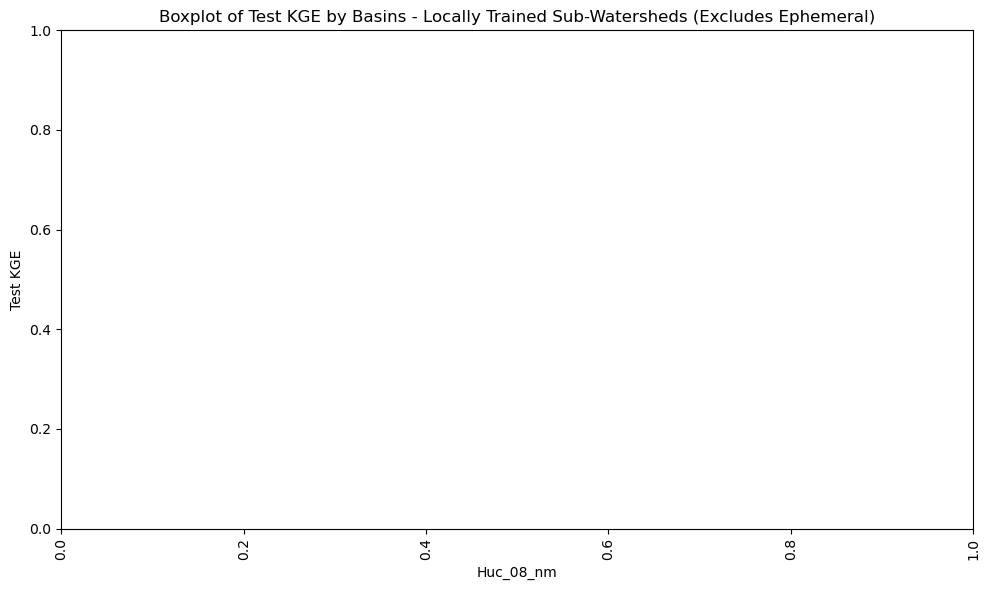

,count,median,mean,std
Huc_08_nm,,,,


In [25]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral)"
vu.plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

# Step 7 Examine by Elevation 

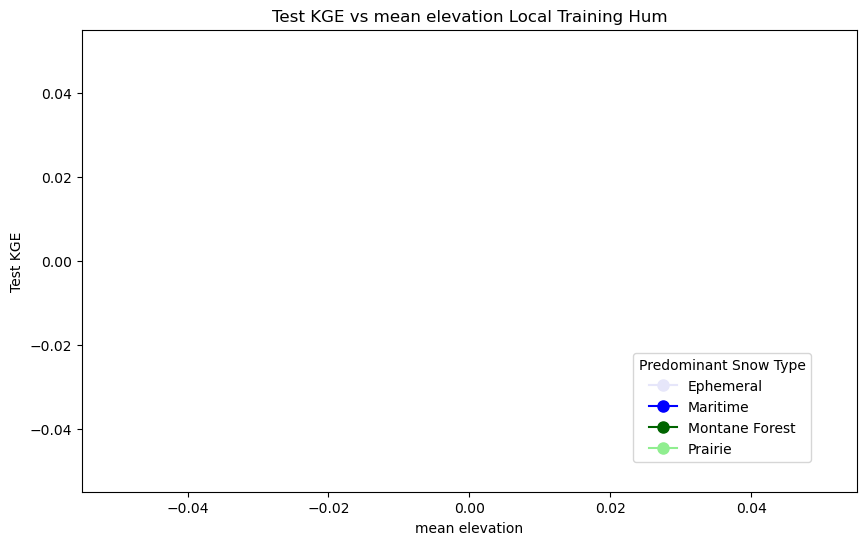

In [26]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
short_name = "Hum"
ttl = f"{y_var_name}_vs_{x_var_name}_Local_Training_{short_name}"
vu.plot_scatter(filtered_df, x_var_name, y_var_name, color_map_snow, title = ttl)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

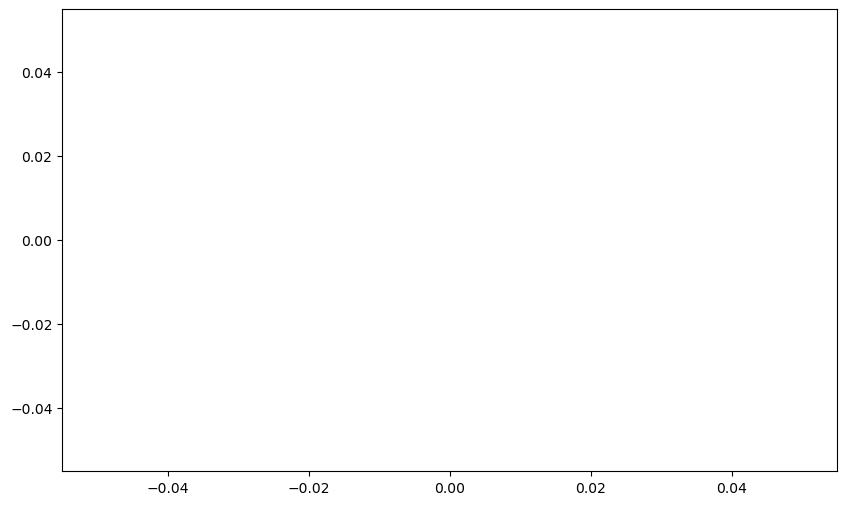

In [27]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
short_name = "Hum"
ttl = f"{y_var_name}_vs_{x_var_name}_Local_Training_{short_name}"
vu.plot_scatter_w_R2(filtered_df, x_var_name, y_var_name, color_map_snow, title = ttl)